In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#for multiple tockets
#50 tockets
# Scarica lista S&P500 da Wikipedia
tickers = pd.read_csv("/home/ceci/ProblemSolving/notebooks/constituents.csv")["Symbol"].tolist()

# Alcuni ticker hanno un punto (es. BRK.B, BF.B) → Yahoo li vuole con trattino
tickers = [t.replace(".", "-") for t in tickers]
data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
data = data.dropna(axis=1, how='all')

/tmp/ipykernel_1686/1040873868.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start="2023-01-01", end="2025-01-01")['Close']
[*********************100%***********************]  503 of 503 completed


In [6]:
nan_frac = data.isna().mean()
# tieni solo colonne con meno del 5% di NaN
ok_cols = nan_frac[nan_frac <= 0.05].index
data_clean = data[ok_cols]
data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')
subset = data_clean.iloc[:, :100] #takes first 100 tockets

/tmp/ipykernel_1686/3329663416.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_clean = data_clean.fillna(method='ffill').fillna(method='bfill')


In [7]:
#marchenko-pastur on real data
import sys
sys.path.append("../src")
from finrmt.data import returns
from finrmt.rmt import mp_bounds

#for multiple tockets defined before

ret = returns(subset)

R = ret.dropna(how="any").to_numpy(dtype=float)   # shape: (T, N)
print("first 5 rows of returns:\n", ret.head())
T, N = R.shape
C = R.T @ R / T

first 5 rows of returns:
 Ticker             A      AAPL      ABBV      ABNB       ABT      ACGL  \
Date                                                                     
2023-01-03       NaN       NaN       NaN       NaN       NaN       NaN   
2023-01-04  0.660901  0.660106  0.552968  1.792072  1.232286  0.267464   
2023-01-05  0.185639 -0.899635 -0.111492 -0.511850 -0.323231  0.119841   
2023-01-06 -1.768677  2.588782  1.307180  0.345651  1.143702  0.936904   
2023-01-09 -0.069889  0.199323 -2.162514  0.300300 -0.147145 -1.335230   

Ticker           ACN      ADBE       ADI       ADM  ...      CINF        CL  \
Date                                                ...                       
2023-01-03       NaN       NaN       NaN       NaN  ...       NaN       NaN   
2023-01-04 -0.271797  0.579761  1.121625 -1.907067  ...  1.423312  0.606601   
2023-01-05 -1.663903 -1.795497 -2.127153 -1.286397  ...  0.149031 -1.431047   
2023-01-06  1.550964  0.570562  1.931655  1.124907  ...  1.8

Covariance matrix shape: (100, 100)
Eigenvalues shape: (100,)
Eigenvectors shape: (100, 100)


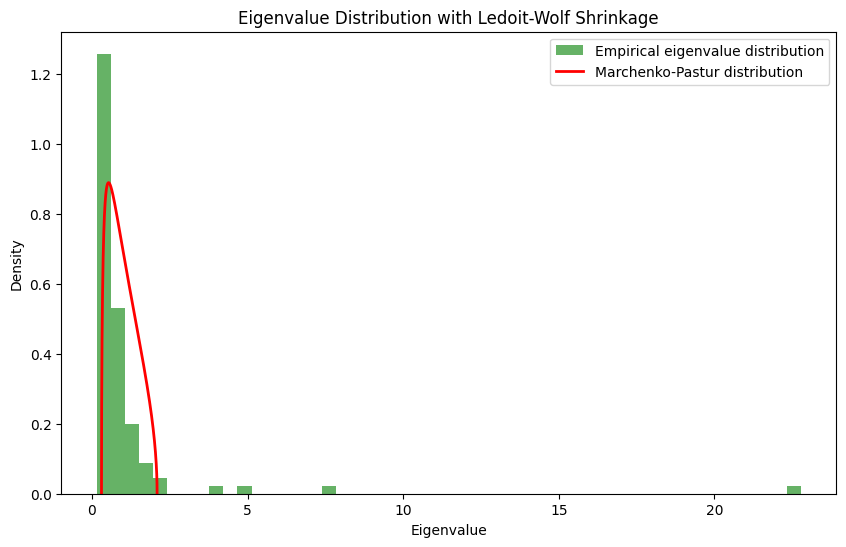

In [8]:
import sys
sys.path.append("../src")
from finrmt.cov import ledoit_wolf
import sklearn 
C_led = ledoit_wolf(ret)
print("Covariance matrix shape:", C_led.shape)  # should be (N, N)  
eigenvalues, eigenvectors = np.linalg.eigh(C_led)
print("Eigenvalues shape:", eigenvalues.shape)  # should be (N,)
print("Eigenvectors shape:", eigenvectors.shape)  # should be (N, N)
eigenvalues = np.sort(eigenvalues)[::-1]  # ordina in ordine decrescente
mp_min, mp_max = mp_bounds(N, T, sigma2=1.0)
plt.figure(figsize=(10, 6))
plt.hist(eigenvalues, bins=50, density=True, alpha=0.6, color='g', label='Empirical eigenvalue distribution')
x = np.linspace(mp_min, mp_max, 1000)
pdf = (T / (2 * np.pi * x * N)) * np.sqrt((mp_max - x) * (x - mp_min))
#ledoit wolf
plt.plot(x, pdf, 'r-', lw=2, label='Marchenko-Pastur distribution')
plt.title('Eigenvalue Distribution with Ledoit-Wolf Shrinkage')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.show()

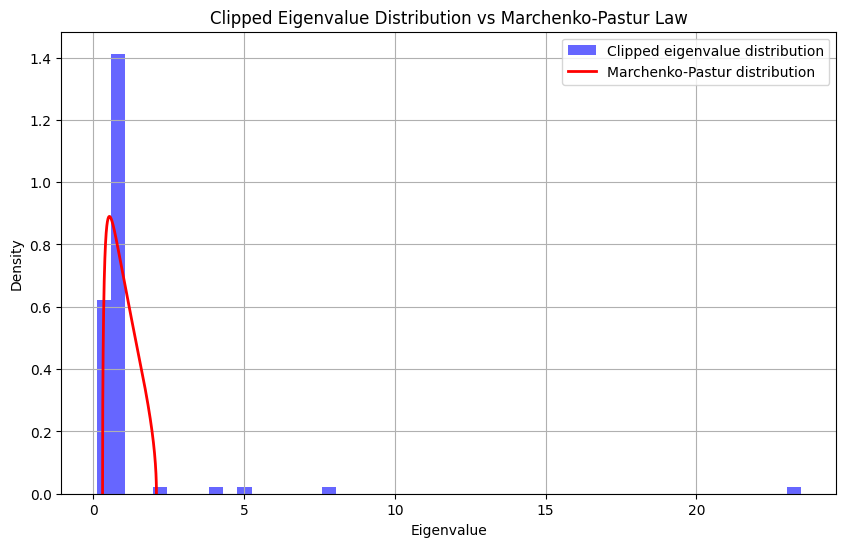

In [9]:
#clipping con la media degli autovalori del bulk

import sys 
sys.path.append("../src")
from finrmt.cov import mp_clip

# Applica il filtro di Marchenko-Pastur
C_clipped = mp_clip(R)
eigenvalues_clipped, _ = np.linalg.eigh(C_clipped)
eigenvalues_clipped = np.sort(eigenvalues_clipped)[::-1]
plt.figure(figsize=(10, 6))
plt.hist(eigenvalues_clipped, bins=50, density=True, alpha=0.6, color='b', label='Clipped eigenvalue distribution')
plt.plot(x, pdf, 'r-', lw=2, label='Marchenko-Pastur distribution')
plt.title('Clipped Eigenvalue Distribution vs Marchenko-Pastur Law')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.legend()
plt.grid()
plt.show()

/tmp/ipykernel_1686/99812627.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


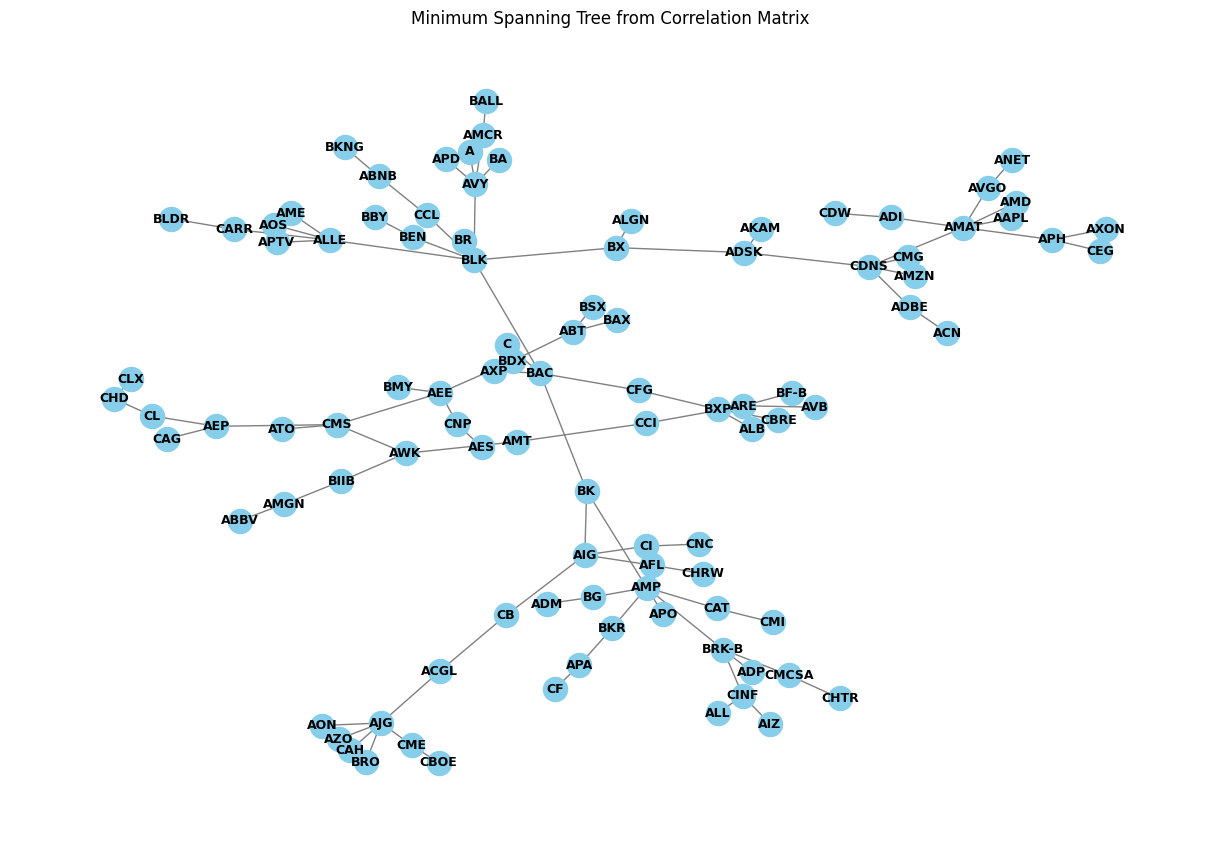

In [12]:
import sys
sys.path.append('../src')
from finrmt.graph import correlation_to_mst
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
labels = ret.columns.tolist()
G = correlation_to_mst(C, labels)

import networkx as nx
import matplotlib.pyplot as plt

pos = nx.spring_layout(G, seed=42)     # ora funziona: i nodi sono stringhe (labels)
plt.figure(figsize=(12, 8))
nx.draw(G, pos,
        with_labels=True,
        node_size=300, node_color='skyblue',
        font_size=9, font_weight='bold',
        edge_color='gray', width=1.0)
plt.title('Minimum Spanning Tree from Correlation Matrix')
plt.tight_layout()
plt.show()

/tmp/ipykernel_1686/1869292943.py:33: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("tab20", max(len(sectors), 1))
/tmp/ipykernel_1686/1869292943.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


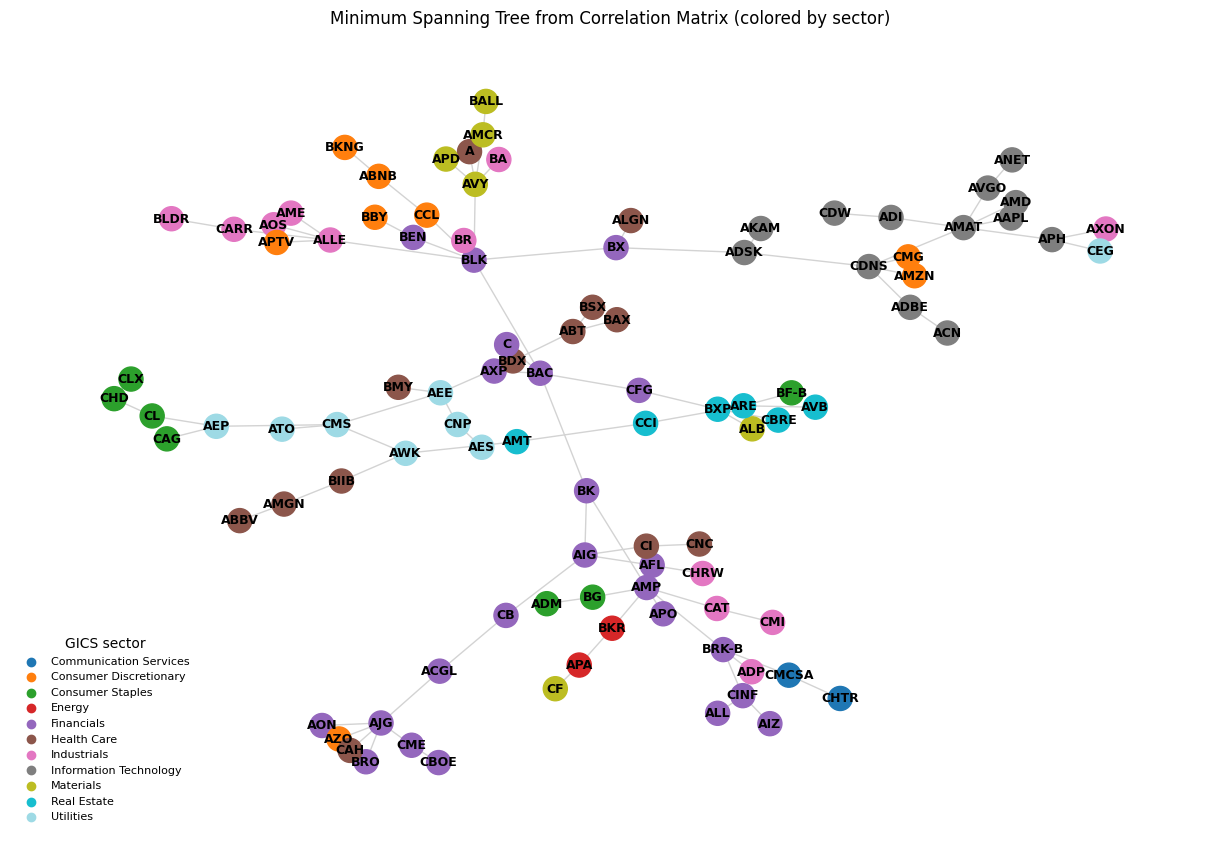

In [13]:
# --- 1) Mapping S&P500: ticker -> GICS sector (da Wikipedia) -----------------
import pandas as pd

def _wiki_to_dash(t):   # "BRK.B" -> "BRK-B"
    return t.replace(".", "-")


def get_sp500_sector_map():
    """
    Restituisce dict { 'AAPL': 'Information Technology', ... }.
    Normalizza i simboli con il trattino (BRK-B, BF-B).
    """
    tickers = pd.read_csv("/home/ceci/ProblemSolving/notebooks/constituents.csv")["Symbol"].tolist()
    sectors = pd.read_csv("/home/ceci/ProblemSolving/notebooks/constituents.csv")["GICS Sector"].tolist()
    tickers = [_wiki_to_dash(t) for t in tickers]
    sector_map = dict(zip(tickers, sectors))
    return sector_map

sector_map = get_sp500_sector_map()


# --- 2) Disegno MST colorato per settore ------------------------------------
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import networkx as nx

def draw_mst_by_sector(G, sector_map, seed=42):
    # settore per ciascun nodo; fallback "Unknown" se non trovato
    node_sectors = [sector_map.get(n, "Unknown") for n in G.nodes()]
    sectors = sorted(set(node_sectors))

    # palette discreta (tab20); se i settori > 20, cicla
    cmap = cm.get_cmap("tab20", max(len(sectors), 1))
    sector_to_color = {s: cmap(i % 20) for i, s in enumerate(sectors)}
    node_colors = [sector_to_color[s] for s in node_sectors]

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G, seed=seed)

    nx.draw(
        G, pos,
        with_labels=True,
        node_size=300,
        node_color=node_colors,
        font_size=9, font_weight="bold",
        edge_color="lightgray", width=1.0
    )
    # legenda compatta
    for s, c in sector_to_color.items():
        plt.scatter([], [], c=[c], label=s)
    plt.legend(
        title="GICS sector", scatterpoints=1, frameon=False,
        fontsize=8, labelspacing=0.5, loc="best"
    )
    plt.title("Minimum Spanning Tree from Correlation Matrix (colored by sector)")
    plt.tight_layout()
    plt.show()

draw_mst_by_sector(G, sector_map)
